In [1]:
import os
from math import pi

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import jdgsim
from jdgsim import construct_initial_state
from jdgsim.integrators import leapfrog
from jdgsim.dynamics import direct_acc
from jdgsim.option_classes import SimulationConfig, SimulationParams, NFWParams, PlummerParams, NFW_POTENTIAL
from jdgsim.initial_condition import Plummer_sphere, ic_two_body
from jdgsim.utils import center_of_mass
from jdgsim.time_integration import time_integration
from jdgsim.units import CodeUnits
from jdgsim.visualization import create_3d_gif,create_3d_gif_velocitycoding, create_projection_gif


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=10_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1_000, 
                          external_accelerations=(), 
                          softening=1e-10) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=10000, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=1000, softening=1e-10, integrator=0, acceleration_scheme=0, external_accelerations=())
SimulationParams(G=1, t_end=np.float64(2.0121262227610366), NFW_params=NFWParams(Mvir=<Quantity 1.62e+11 solMass>, r_s=<Quantity 15.3 kpc>, c=10, d_c=1.4888043637074615), Plummer_params=PlummerParams(a=np.float64(0.1), Mtot=np.float64(1.0)), PointMass_params=PointMassParams(M=<Quantity 1. solMass>))


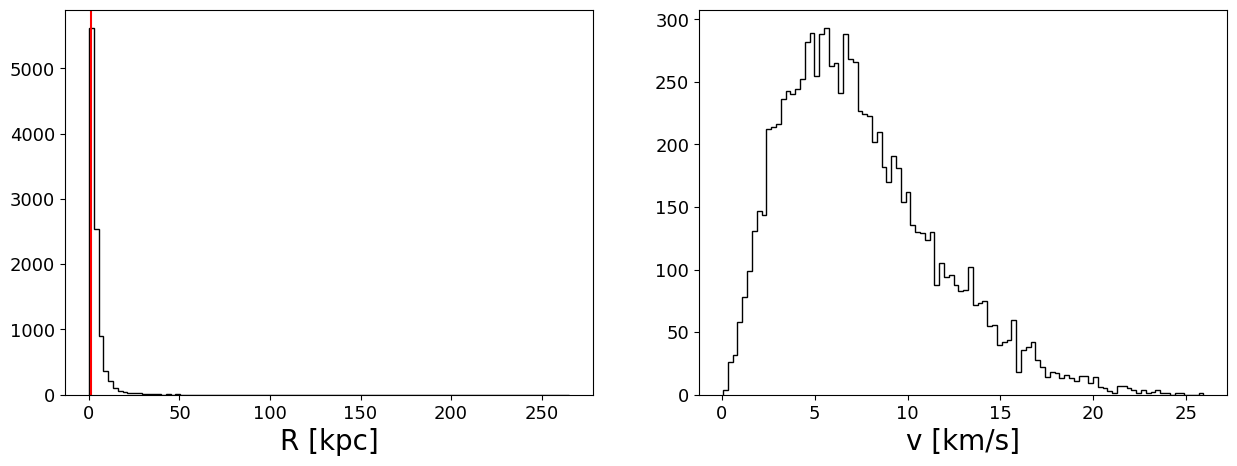

In [4]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

In [5]:
if config.return_snapshots: 
    snapshots = time_integration(initial_state, mass, config, params)
else:
    final_state = time_integration(initial_state, mass, config, params)


/Users/giuseppeviterbo/micromamba/envs/jdgsim/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/Users/giuseppeviterbo/micromamba/envs/jdgsim/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


In [ ]:
fig = plt.figure(figsize=(10, 10),) 
ax = fig.add_subplot(111, projection='3d')

# Normalize the times to the range [0, 1] for colormap
times = (snapshots.times * code_units.code_time).to(u.Gyr)
norm_times = (times - times.min()) / (times.max() - times.min())

# Generate colors using a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(norm_times)
for i in range(0, len(snapshots.states), 10):
    sc = ax.scatter((snapshots.states[i, :, 0, 0] * code_units.code_length).to(u.kpc).value, 
                    (snapshots.states[i, :, 0, 1] * code_units.code_length).to(u.kpc).value,
                    (snapshots.states[i, :, 0, 2] * code_units.code_length).to(u.kpc).value,
                    color=colors[i])

ax.scatter(0, 0, 0, c='r', s=100)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


cbar = plt.colorbar(sc, location='top')
cbar.set_label('Simulation percentage')
plt.legend()


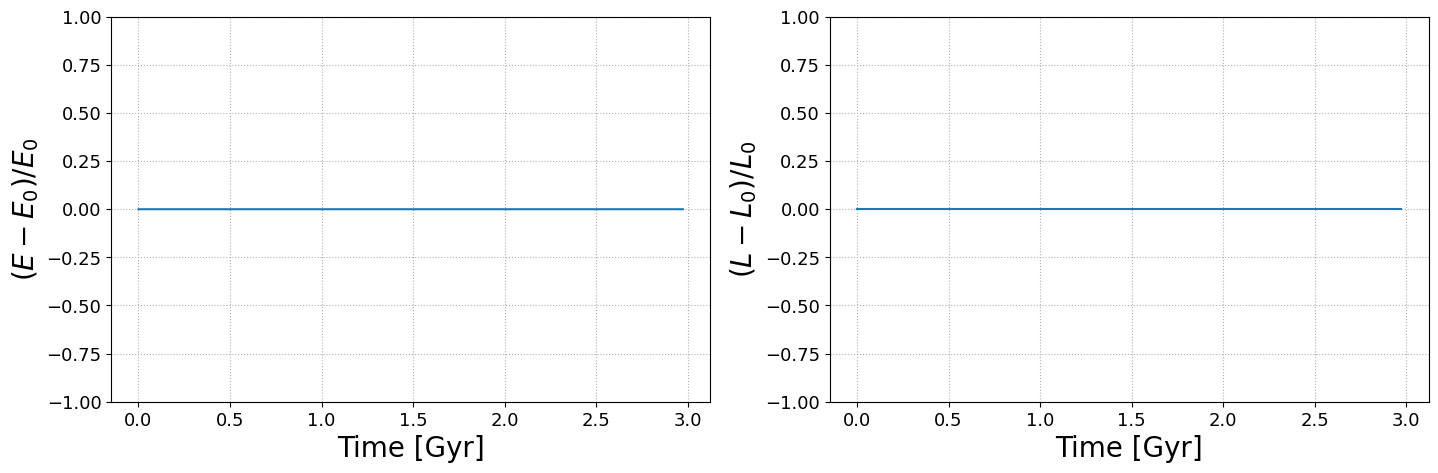

In [ ]:
fig = plt.figure(figsize=(17, 5))
ax = fig.add_subplot(121)
Delta_E = ((snapshots.total_energy - snapshots.total_energy[0])/snapshots.total_energy[0])
ax.plot((snapshots.times * code_units.code_time).to(u.Gyr), Delta_E,)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$(E - E_0)/E_0$')
ax.set_ylim(-1, 1)
ax.grid(linestyle='dotted')

ax = fig.add_subplot(122)
Delta_AngMom = ((snapshots.angular_momentum - snapshots.angular_momentum[0])/snapshots.angular_momentum[0])
ax.plot((snapshots.times * code_units.code_time).to(u.Gyr), Delta_AngMom[:, 2], )
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$(L - L_0)/L_0$')
ax.set_ylim(-1, 1)
ax.grid(linestyle='dotted')


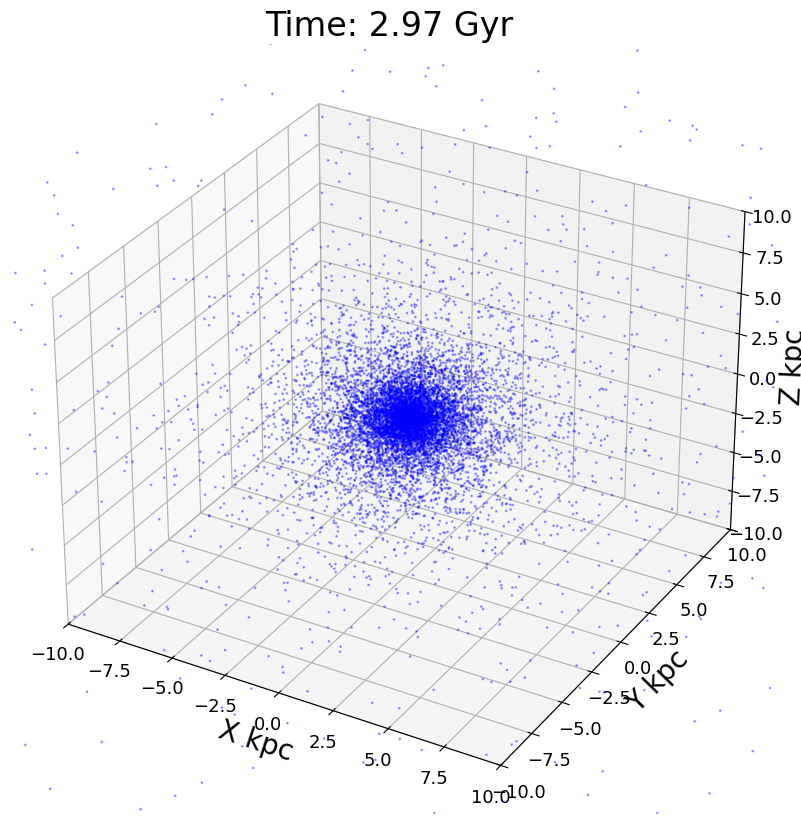

In [ ]:
create_3d_gif(snapshots, 
              ax_lim=(10*params.Plummer_params.a*code_units.code_length).value, 
              code_units=code_units, 
              plotting_units_length=u.kpc, 
              plot_units_time=u.Gyr, 
              filename='simulation_Plummer.gif')

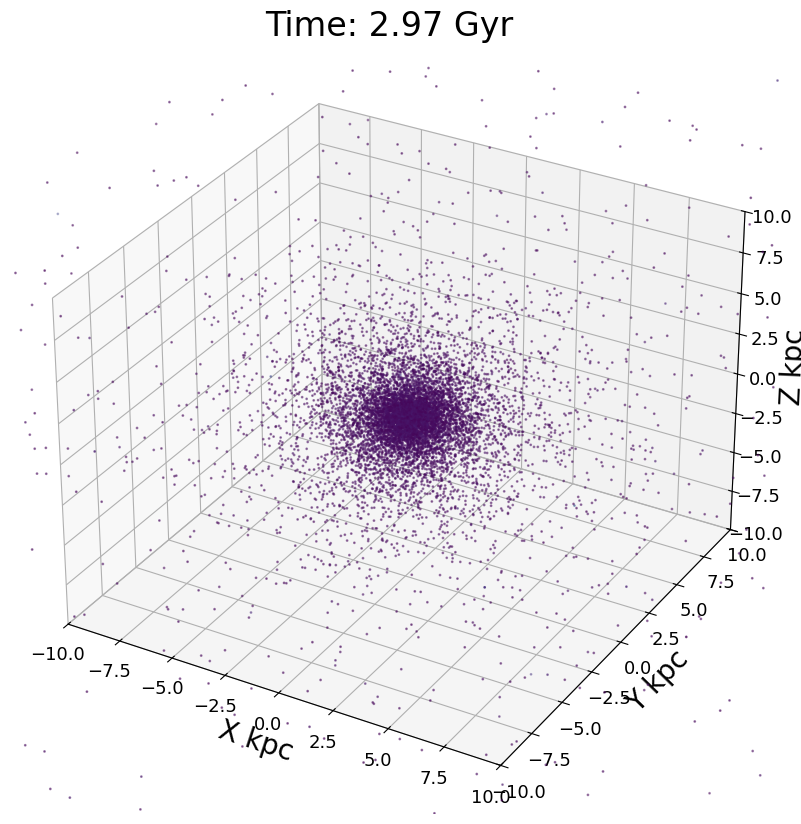

In [7]:
create_3d_gif_velocitycoding(snapshots, 
                            ax_lim=(10*params.Plummer_params.a*code_units.code_length).value, 
                            code_units=code_units, 
                            plotting_units_length=u.kpc, 
                            plot_units_time=u.Gyr, 
                            filename='simulation_Plummer_velocitycoding.gif')

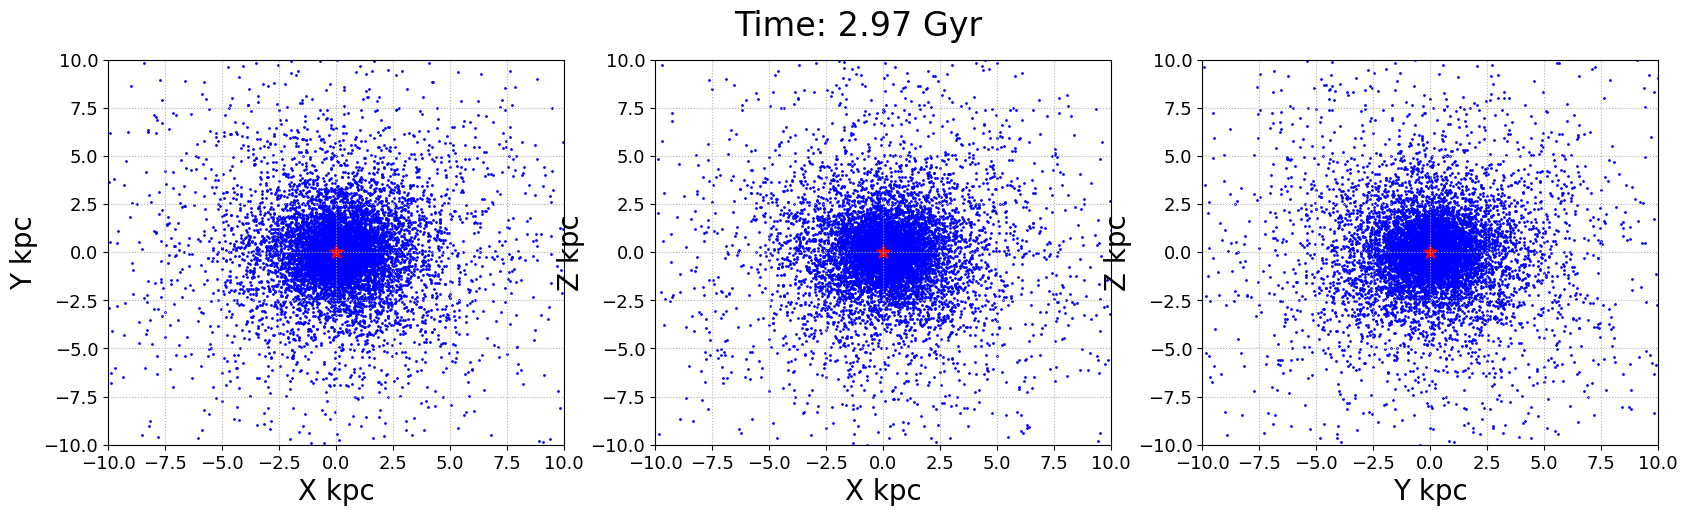

In [ ]:
create_projection_gif(snapshots=snapshots,
                      ax_lim=(10*params.Plummer_params.a*code_units.code_length).value,  
                      code_units=code_units, 
                      plotting_units_length=u.kpc, 
                      plot_units_time=u.Gyr, 
                      filename='simulation_projection_Plummer.gif')

In [ ]:
1